Get libraries

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from PROMETHEE import PROMETHEE_2, optimize_PROM2_original, optimize_newconstraint, optimize_PROM2_original_positive_beta
from sklearn.preprocessing import StandardScaler 

Creating data using skearn make_blobs procedure. 

The data is clustered around centers.

In [2]:
centers_ = [(2, 2, 2, 2, 2), (7, 7, 7, 7, 7), (10, 10, 10, 10, 10), (10,10,10,10,10)]

X, y = make_blobs(n_samples=[1, 7, 6, 1], centers=centers_, n_features=5, cluster_std= [0.25, 2.5, 2.5, 0.25], random_state=0)

In [3]:
m, n = X.shape
X

array([[ 4.5568053 ,  9.37522104,  6.62160698,  6.74195287,  8.02649625],
       [ 7.39087242, 10.0757267 , 10.00594962,  6.03168296,  6.24424312],
       [ 0.61752546,  8.63404649,  9.1610905 ,  5.14458745, 12.67438656],
       [11.07082968, 10.16629306, 10.75617974,  8.41419477,  9.09314709],
       [ 7.36010893, 10.63568377,  8.90259431,  7.30418754,  8.10965808],
       [10.18227264, 10.03224573, 10.28485017,  9.69129354, 10.10058541],
       [ 8.99554766,  5.92450413, 11.15695564,  7.73175409, 10.12986349],
       [ 3.36408581,  7.11439629,  6.53204037, 10.83194804, 10.67339692],
       [ 8.90481425,  6.8680116 , 11.94372589,  5.96525538,  9.4681493 ],
       [ 7.37861759,  6.44995516,  5.73432452, 14.87693849,  8.72586955],
       [ 8.31884888,  9.1011171 ,  7.96713429,  5.68429349, 10.44356536],
       [ 7.7613336 , 10.96725624,  8.72298716,  7.04841954,  9.92954443],
       [ 7.83418582, 10.73519768,  6.48710434,  7.78266925,  4.86476065],
       [ 7.38736856,  7.9454063 ,  4.7

In [5]:
#print the decision matrix
A = pd.DataFrame(X, columns = ['$g_' + str(i+1) + '$' for i in range (X.shape[1])], index= ['$a_' + str(i+1) + '$' for i in range (X.shape[0])])
A

,$g_1$,$g_2$,$g_3$,$g_4$,$g_5$
$a_1$,4.556805,9.375221,6.621607,6.741953,8.026496
$a_2$,7.390872,10.075727,10.005950,6.031683,6.244243
$a_3$,0.617525,8.634046,9.161090,5.144587,12.674387
$a_4$,11.070830,10.166293,10.756180,8.414195,9.093147
$a_5$,7.360109,10.635684,8.902594,7.304188,8.109658
$a_6$,10.182273,10.032246,10.284850,9.691294,10.100585
$a_7$,8.995548,5.924504,11.156956,7.731754,10.129863
$a_8$,3.364086,7.114396,6.532040,10.831948,10.673397
$a_9$,8.904814,6.868012,11.943726,5.965255,9.468149
$a_10$,7.378618,6.449955,5.734325,14.876938,8.725870


Lets first run a basic PROMETHEE II using:

- equal weights
- $q_j$ = 1.5
- $p_j$ = 3.5
- preference function type 5

In [6]:
A.to_csv('Toy_example.csv')

In [7]:
#solve the problem with PROMETHEE II
net_flows_toy = PROMETHEE_2 (X, [1.5 for i in range (n)], [3.5 for i in range (n)], [0 for i in range (n)], [1/n for i in range (n)], [5 for i in range (n)])[1]
net_flows_toy = pd.DataFrame(net_flows_toy, index = A.index, columns=["$\phi$"])

In [8]:
net_flows_toy["Position"] = net_flows_toy.rank(ascending=False)
net_flows_toy

,$\phi$,Position
$a_1$,-0.156410,13.0
$a_2$,0.054418,9.0
$a_3$,-0.015263,10.0
$a_4$,0.408791,2.0
$a_5$,0.145480,4.0
$a_6$,0.429092,1.0
$a_7$,0.132334,5.0
$a_8$,-0.075429,11.0
$a_9$,0.125919,6.0
$a_10$,0.058569,8.0


In [9]:
pgrn = np.random.RandomState(0) # create a random number generator with a fixed seed

n_simulations = 10000 # number of simulations
W = np.zeros(shape = (n, n_simulations)) # weight matrix
P = np.zeros(shape = (n, n_simulations)) # preference threshold matrix
Q = np.zeros(shape = (n, n_simulations)) # indifference threshold matrix

Net_Flows = np.zeros(shape = (m, n_simulations)) # matrix that will receive the PROMETHEE II net flows
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]


s_curve = [0 for j in range (n)] # it will not be used 
pref = [5 for j in range (n)] # We will always use pref. function 5

for s in range (n_simulations):
    W [:,s] = pgrn.dirichlet(np.ones(n),size=1).reshape(n) # weights come from a dirichlet distribution
    Q [:,s] = pgrn.uniform (1,2.5, n) # q_j between 1 and 2.5
    P [:,s] = pgrn.uniform (2.5, 4, n) # p_j between 2.5 and 4
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed
simulation 31 completed
simulation 32 completed
simulation 33 completed
simulation 34 completed
simulation 35 completed
simulation 36 completed
simulation 37 completed
simulation 38 completed
simulation 39 completed
simulation 40 completed
simulation 41 completed
simulation 42 completed
s

simulation 344 completed
simulation 345 completed
simulation 346 completed
simulation 347 completed
simulation 348 completed
simulation 349 completed
simulation 350 completed
simulation 351 completed
simulation 352 completed
simulation 353 completed
simulation 354 completed
simulation 355 completed
simulation 356 completed
simulation 357 completed
simulation 358 completed
simulation 359 completed
simulation 360 completed
simulation 361 completed
simulation 362 completed
simulation 363 completed
simulation 364 completed
simulation 365 completed
simulation 366 completed
simulation 367 completed
simulation 368 completed
simulation 369 completed
simulation 370 completed
simulation 371 completed
simulation 372 completed
simulation 373 completed
simulation 374 completed
simulation 375 completed
simulation 376 completed
simulation 377 completed
simulation 378 completed
simulation 379 completed
simulation 380 completed
simulation 381 completed
simulation 382 completed
simulation 383 completed


simulation 712 completed
simulation 713 completed
simulation 714 completed
simulation 715 completed
simulation 716 completed
simulation 717 completed
simulation 718 completed
simulation 719 completed
simulation 720 completed
simulation 721 completed
simulation 722 completed
simulation 723 completed
simulation 724 completed
simulation 725 completed
simulation 726 completed
simulation 727 completed
simulation 728 completed
simulation 729 completed
simulation 730 completed
simulation 731 completed
simulation 732 completed
simulation 733 completed
simulation 734 completed
simulation 735 completed
simulation 736 completed
simulation 737 completed
simulation 738 completed
simulation 739 completed
simulation 740 completed
simulation 741 completed
simulation 742 completed
simulation 743 completed
simulation 744 completed
simulation 745 completed
simulation 746 completed
simulation 747 completed
simulation 748 completed
simulation 749 completed
simulation 750 completed
simulation 751 completed


simulation 1068 completed
simulation 1069 completed
simulation 1070 completed
simulation 1071 completed
simulation 1072 completed
simulation 1073 completed
simulation 1074 completed
simulation 1075 completed
simulation 1076 completed
simulation 1077 completed
simulation 1078 completed
simulation 1079 completed
simulation 1080 completed
simulation 1081 completed
simulation 1082 completed
simulation 1083 completed
simulation 1084 completed
simulation 1085 completed
simulation 1086 completed
simulation 1087 completed
simulation 1088 completed
simulation 1089 completed
simulation 1090 completed
simulation 1091 completed
simulation 1092 completed
simulation 1093 completed
simulation 1094 completed
simulation 1095 completed
simulation 1096 completed
simulation 1097 completed
simulation 1098 completed
simulation 1099 completed
simulation 1100 completed
simulation 1101 completed
simulation 1102 completed
simulation 1103 completed
simulation 1104 completed
simulation 1105 completed
simulation 1

simulation 1453 completed
simulation 1454 completed
simulation 1455 completed
simulation 1456 completed
simulation 1457 completed
simulation 1458 completed
simulation 1459 completed
simulation 1460 completed
simulation 1461 completed
simulation 1462 completed
simulation 1463 completed
simulation 1464 completed
simulation 1465 completed
simulation 1466 completed
simulation 1467 completed
simulation 1468 completed
simulation 1469 completed
simulation 1470 completed
simulation 1471 completed
simulation 1472 completed
simulation 1473 completed
simulation 1474 completed
simulation 1475 completed
simulation 1476 completed
simulation 1477 completed
simulation 1478 completed
simulation 1479 completed
simulation 1480 completed
simulation 1481 completed
simulation 1482 completed
simulation 1483 completed
simulation 1484 completed
simulation 1485 completed
simulation 1486 completed
simulation 1487 completed
simulation 1488 completed
simulation 1489 completed
simulation 1490 completed
simulation 1

simulation 1838 completed
simulation 1839 completed
simulation 1840 completed
simulation 1841 completed
simulation 1842 completed
simulation 1843 completed
simulation 1844 completed
simulation 1845 completed
simulation 1846 completed
simulation 1847 completed
simulation 1848 completed
simulation 1849 completed
simulation 1850 completed
simulation 1851 completed
simulation 1852 completed
simulation 1853 completed
simulation 1854 completed
simulation 1855 completed
simulation 1856 completed
simulation 1857 completed
simulation 1858 completed
simulation 1859 completed
simulation 1860 completed
simulation 1861 completed
simulation 1862 completed
simulation 1863 completed
simulation 1864 completed
simulation 1865 completed
simulation 1866 completed
simulation 1867 completed
simulation 1868 completed
simulation 1869 completed
simulation 1870 completed
simulation 1871 completed
simulation 1872 completed
simulation 1873 completed
simulation 1874 completed
simulation 1875 completed
simulation 1

simulation 2192 completed
simulation 2193 completed
simulation 2194 completed
simulation 2195 completed
simulation 2196 completed
simulation 2197 completed
simulation 2198 completed
simulation 2199 completed
simulation 2200 completed
simulation 2201 completed
simulation 2202 completed
simulation 2203 completed
simulation 2204 completed
simulation 2205 completed
simulation 2206 completed
simulation 2207 completed
simulation 2208 completed
simulation 2209 completed
simulation 2210 completed
simulation 2211 completed
simulation 2212 completed
simulation 2213 completed
simulation 2214 completed
simulation 2215 completed
simulation 2216 completed
simulation 2217 completed
simulation 2218 completed
simulation 2219 completed
simulation 2220 completed
simulation 2221 completed
simulation 2222 completed
simulation 2223 completed
simulation 2224 completed
simulation 2225 completed
simulation 2226 completed
simulation 2227 completed
simulation 2228 completed
simulation 2229 completed
simulation 2

simulation 2549 completed
simulation 2550 completed
simulation 2551 completed
simulation 2552 completed
simulation 2553 completed
simulation 2554 completed
simulation 2555 completed
simulation 2556 completed
simulation 2557 completed
simulation 2558 completed
simulation 2559 completed
simulation 2560 completed
simulation 2561 completed
simulation 2562 completed
simulation 2563 completed
simulation 2564 completed
simulation 2565 completed
simulation 2566 completed
simulation 2567 completed
simulation 2568 completed
simulation 2569 completed
simulation 2570 completed
simulation 2571 completed
simulation 2572 completed
simulation 2573 completed
simulation 2574 completed
simulation 2575 completed
simulation 2576 completed
simulation 2577 completed
simulation 2578 completed
simulation 2579 completed
simulation 2580 completed
simulation 2581 completed
simulation 2582 completed
simulation 2583 completed
simulation 2584 completed
simulation 2585 completed
simulation 2586 completed
simulation 2

simulation 2905 completed
simulation 2906 completed
simulation 2907 completed
simulation 2908 completed
simulation 2909 completed
simulation 2910 completed
simulation 2911 completed
simulation 2912 completed
simulation 2913 completed
simulation 2914 completed
simulation 2915 completed
simulation 2916 completed
simulation 2917 completed
simulation 2918 completed
simulation 2919 completed
simulation 2920 completed
simulation 2921 completed
simulation 2922 completed
simulation 2923 completed
simulation 2924 completed
simulation 2925 completed
simulation 2926 completed
simulation 2927 completed
simulation 2928 completed
simulation 2929 completed
simulation 2930 completed
simulation 2931 completed
simulation 2932 completed
simulation 2933 completed
simulation 2934 completed
simulation 2935 completed
simulation 2936 completed
simulation 2937 completed
simulation 2938 completed
simulation 2939 completed
simulation 2940 completed
simulation 2941 completed
simulation 2942 completed
simulation 2

simulation 3229 completed
simulation 3230 completed
simulation 3231 completed
simulation 3232 completed
simulation 3233 completed
simulation 3234 completed
simulation 3235 completed
simulation 3236 completed
simulation 3237 completed
simulation 3238 completed
simulation 3239 completed
simulation 3240 completed
simulation 3241 completed
simulation 3242 completed
simulation 3243 completed
simulation 3244 completed
simulation 3245 completed
simulation 3246 completed
simulation 3247 completed
simulation 3248 completed
simulation 3249 completed
simulation 3250 completed
simulation 3251 completed
simulation 3252 completed
simulation 3253 completed
simulation 3254 completed
simulation 3255 completed
simulation 3256 completed
simulation 3257 completed
simulation 3258 completed
simulation 3259 completed
simulation 3260 completed
simulation 3261 completed
simulation 3262 completed
simulation 3263 completed
simulation 3264 completed
simulation 3265 completed
simulation 3266 completed
simulation 3

simulation 3586 completed
simulation 3587 completed
simulation 3588 completed
simulation 3589 completed
simulation 3590 completed
simulation 3591 completed
simulation 3592 completed
simulation 3593 completed
simulation 3594 completed
simulation 3595 completed
simulation 3596 completed
simulation 3597 completed
simulation 3598 completed
simulation 3599 completed
simulation 3600 completed
simulation 3601 completed
simulation 3602 completed
simulation 3603 completed
simulation 3604 completed
simulation 3605 completed
simulation 3606 completed
simulation 3607 completed
simulation 3608 completed
simulation 3609 completed
simulation 3610 completed
simulation 3611 completed
simulation 3612 completed
simulation 3613 completed
simulation 3614 completed
simulation 3615 completed
simulation 3616 completed
simulation 3617 completed
simulation 3618 completed
simulation 3619 completed
simulation 3620 completed
simulation 3621 completed
simulation 3622 completed
simulation 3623 completed
simulation 3

simulation 3964 completed
simulation 3965 completed
simulation 3966 completed
simulation 3967 completed
simulation 3968 completed
simulation 3969 completed
simulation 3970 completed
simulation 3971 completed
simulation 3972 completed
simulation 3973 completed
simulation 3974 completed
simulation 3975 completed
simulation 3976 completed
simulation 3977 completed
simulation 3978 completed
simulation 3979 completed
simulation 3980 completed
simulation 3981 completed
simulation 3982 completed
simulation 3983 completed
simulation 3984 completed
simulation 3985 completed
simulation 3986 completed
simulation 3987 completed
simulation 3988 completed
simulation 3989 completed
simulation 3990 completed
simulation 3991 completed
simulation 3992 completed
simulation 3993 completed
simulation 3994 completed
simulation 3995 completed
simulation 3996 completed
simulation 3997 completed
simulation 3998 completed
simulation 3999 completed
simulation 4000 completed
simulation 4001 completed
simulation 4

simulation 4325 completed
simulation 4326 completed
simulation 4327 completed
simulation 4328 completed
simulation 4329 completed
simulation 4330 completed
simulation 4331 completed
simulation 4332 completed
simulation 4333 completed
simulation 4334 completed
simulation 4335 completed
simulation 4336 completed
simulation 4337 completed
simulation 4338 completed
simulation 4339 completed
simulation 4340 completed
simulation 4341 completed
simulation 4342 completed
simulation 4343 completed
simulation 4344 completed
simulation 4345 completed
simulation 4346 completed
simulation 4347 completed
simulation 4348 completed
simulation 4349 completed
simulation 4350 completed
simulation 4351 completed
simulation 4352 completed
simulation 4353 completed
simulation 4354 completed
simulation 4355 completed
simulation 4356 completed
simulation 4357 completed
simulation 4358 completed
simulation 4359 completed
simulation 4360 completed
simulation 4361 completed
simulation 4362 completed
simulation 4

simulation 4691 completed
simulation 4692 completed
simulation 4693 completed
simulation 4694 completed
simulation 4695 completed
simulation 4696 completed
simulation 4697 completed
simulation 4698 completed
simulation 4699 completed
simulation 4700 completed
simulation 4701 completed
simulation 4702 completed
simulation 4703 completed
simulation 4704 completed
simulation 4705 completed
simulation 4706 completed
simulation 4707 completed
simulation 4708 completed
simulation 4709 completed
simulation 4710 completed
simulation 4711 completed
simulation 4712 completed
simulation 4713 completed
simulation 4714 completed
simulation 4715 completed
simulation 4716 completed
simulation 4717 completed
simulation 4718 completed
simulation 4719 completed
simulation 4720 completed
simulation 4721 completed
simulation 4722 completed
simulation 4723 completed
simulation 4724 completed
simulation 4725 completed
simulation 4726 completed
simulation 4727 completed
simulation 4728 completed
simulation 4

simulation 5021 completed
simulation 5022 completed
simulation 5023 completed
simulation 5024 completed
simulation 5025 completed
simulation 5026 completed
simulation 5027 completed
simulation 5028 completed
simulation 5029 completed
simulation 5030 completed
simulation 5031 completed
simulation 5032 completed
simulation 5033 completed
simulation 5034 completed
simulation 5035 completed
simulation 5036 completed
simulation 5037 completed
simulation 5038 completed
simulation 5039 completed
simulation 5040 completed
simulation 5041 completed
simulation 5042 completed
simulation 5043 completed
simulation 5044 completed
simulation 5045 completed
simulation 5046 completed
simulation 5047 completed
simulation 5048 completed
simulation 5049 completed
simulation 5050 completed
simulation 5051 completed
simulation 5052 completed
simulation 5053 completed
simulation 5054 completed
simulation 5055 completed
simulation 5056 completed
simulation 5057 completed
simulation 5058 completed
simulation 5

simulation 5376 completed
simulation 5377 completed
simulation 5378 completed
simulation 5379 completed
simulation 5380 completed
simulation 5381 completed
simulation 5382 completed
simulation 5383 completed
simulation 5384 completed
simulation 5385 completed
simulation 5386 completed
simulation 5387 completed
simulation 5388 completed
simulation 5389 completed
simulation 5390 completed
simulation 5391 completed
simulation 5392 completed
simulation 5393 completed
simulation 5394 completed
simulation 5395 completed
simulation 5396 completed
simulation 5397 completed
simulation 5398 completed
simulation 5399 completed
simulation 5400 completed
simulation 5401 completed
simulation 5402 completed
simulation 5403 completed
simulation 5404 completed
simulation 5405 completed
simulation 5406 completed
simulation 5407 completed
simulation 5408 completed
simulation 5409 completed
simulation 5410 completed
simulation 5411 completed
simulation 5412 completed
simulation 5413 completed
simulation 5

simulation 5734 completed
simulation 5735 completed
simulation 5736 completed
simulation 5737 completed
simulation 5738 completed
simulation 5739 completed
simulation 5740 completed
simulation 5741 completed
simulation 5742 completed
simulation 5743 completed
simulation 5744 completed
simulation 5745 completed
simulation 5746 completed
simulation 5747 completed
simulation 5748 completed
simulation 5749 completed
simulation 5750 completed
simulation 5751 completed
simulation 5752 completed
simulation 5753 completed
simulation 5754 completed
simulation 5755 completed
simulation 5756 completed
simulation 5757 completed
simulation 5758 completed
simulation 5759 completed
simulation 5760 completed
simulation 5761 completed
simulation 5762 completed
simulation 5763 completed
simulation 5764 completed
simulation 5765 completed
simulation 5766 completed
simulation 5767 completed
simulation 5768 completed
simulation 5769 completed
simulation 5770 completed
simulation 5771 completed
simulation 5

simulation 6109 completed
simulation 6110 completed
simulation 6111 completed
simulation 6112 completed
simulation 6113 completed
simulation 6114 completed
simulation 6115 completed
simulation 6116 completed
simulation 6117 completed
simulation 6118 completed
simulation 6119 completed
simulation 6120 completed
simulation 6121 completed
simulation 6122 completed
simulation 6123 completed
simulation 6124 completed
simulation 6125 completed
simulation 6126 completed
simulation 6127 completed
simulation 6128 completed
simulation 6129 completed
simulation 6130 completed
simulation 6131 completed
simulation 6132 completed
simulation 6133 completed
simulation 6134 completed
simulation 6135 completed
simulation 6136 completed
simulation 6137 completed
simulation 6138 completed
simulation 6139 completed
simulation 6140 completed
simulation 6141 completed
simulation 6142 completed
simulation 6143 completed
simulation 6144 completed
simulation 6145 completed
simulation 6146 completed
simulation 6

simulation 6445 completed
simulation 6446 completed
simulation 6447 completed
simulation 6448 completed
simulation 6449 completed
simulation 6450 completed
simulation 6451 completed
simulation 6452 completed
simulation 6453 completed
simulation 6454 completed
simulation 6455 completed
simulation 6456 completed
simulation 6457 completed
simulation 6458 completed
simulation 6459 completed
simulation 6460 completed
simulation 6461 completed
simulation 6462 completed
simulation 6463 completed
simulation 6464 completed
simulation 6465 completed
simulation 6466 completed
simulation 6467 completed
simulation 6468 completed
simulation 6469 completed
simulation 6470 completed
simulation 6471 completed
simulation 6472 completed
simulation 6473 completed
simulation 6474 completed
simulation 6475 completed
simulation 6476 completed
simulation 6477 completed
simulation 6478 completed
simulation 6479 completed
simulation 6480 completed
simulation 6481 completed
simulation 6482 completed
simulation 6

simulation 6834 completed
simulation 6835 completed
simulation 6836 completed
simulation 6837 completed
simulation 6838 completed
simulation 6839 completed
simulation 6840 completed
simulation 6841 completed
simulation 6842 completed
simulation 6843 completed
simulation 6844 completed
simulation 6845 completed
simulation 6846 completed
simulation 6847 completed
simulation 6848 completed
simulation 6849 completed
simulation 6850 completed
simulation 6851 completed
simulation 6852 completed
simulation 6853 completed
simulation 6854 completed
simulation 6855 completed
simulation 6856 completed
simulation 6857 completed
simulation 6858 completed
simulation 6859 completed
simulation 6860 completed
simulation 6861 completed
simulation 6862 completed
simulation 6863 completed
simulation 6864 completed
simulation 6865 completed
simulation 6866 completed
simulation 6867 completed
simulation 6868 completed
simulation 6869 completed
simulation 6870 completed
simulation 6871 completed
simulation 6

simulation 7197 completed
simulation 7198 completed
simulation 7199 completed
simulation 7200 completed
simulation 7201 completed
simulation 7202 completed
simulation 7203 completed
simulation 7204 completed
simulation 7205 completed
simulation 7206 completed
simulation 7207 completed
simulation 7208 completed
simulation 7209 completed
simulation 7210 completed
simulation 7211 completed
simulation 7212 completed
simulation 7213 completed
simulation 7214 completed
simulation 7215 completed
simulation 7216 completed
simulation 7217 completed
simulation 7218 completed
simulation 7219 completed
simulation 7220 completed
simulation 7221 completed
simulation 7222 completed
simulation 7223 completed
simulation 7224 completed
simulation 7225 completed
simulation 7226 completed
simulation 7227 completed
simulation 7228 completed
simulation 7229 completed
simulation 7230 completed
simulation 7231 completed
simulation 7232 completed
simulation 7233 completed
simulation 7234 completed
simulation 7

simulation 7546 completed
simulation 7547 completed
simulation 7548 completed
simulation 7549 completed
simulation 7550 completed
simulation 7551 completed
simulation 7552 completed
simulation 7553 completed
simulation 7554 completed
simulation 7555 completed
simulation 7556 completed
simulation 7557 completed
simulation 7558 completed
simulation 7559 completed
simulation 7560 completed
simulation 7561 completed
simulation 7562 completed
simulation 7563 completed
simulation 7564 completed
simulation 7565 completed
simulation 7566 completed
simulation 7567 completed
simulation 7568 completed
simulation 7569 completed
simulation 7570 completed
simulation 7571 completed
simulation 7572 completed
simulation 7573 completed
simulation 7574 completed
simulation 7575 completed
simulation 7576 completed
simulation 7577 completed
simulation 7578 completed
simulation 7579 completed
simulation 7580 completed
simulation 7581 completed
simulation 7582 completed
simulation 7583 completed
simulation 7

simulation 7904 completed
simulation 7905 completed
simulation 7906 completed
simulation 7907 completed
simulation 7908 completed
simulation 7909 completed
simulation 7910 completed
simulation 7911 completed
simulation 7912 completed
simulation 7913 completed
simulation 7914 completed
simulation 7915 completed
simulation 7916 completed
simulation 7917 completed
simulation 7918 completed
simulation 7919 completed
simulation 7920 completed
simulation 7921 completed
simulation 7922 completed
simulation 7923 completed
simulation 7924 completed
simulation 7925 completed
simulation 7926 completed
simulation 7927 completed
simulation 7928 completed
simulation 7929 completed
simulation 7930 completed
simulation 7931 completed
simulation 7932 completed
simulation 7933 completed
simulation 7934 completed
simulation 7935 completed
simulation 7936 completed
simulation 7937 completed
simulation 7938 completed
simulation 7939 completed
simulation 7940 completed
simulation 7941 completed
simulation 7

simulation 8275 completed
simulation 8276 completed
simulation 8277 completed
simulation 8278 completed
simulation 8279 completed
simulation 8280 completed
simulation 8281 completed
simulation 8282 completed
simulation 8283 completed
simulation 8284 completed
simulation 8285 completed
simulation 8286 completed
simulation 8287 completed
simulation 8288 completed
simulation 8289 completed
simulation 8290 completed
simulation 8291 completed
simulation 8292 completed
simulation 8293 completed
simulation 8294 completed
simulation 8295 completed
simulation 8296 completed
simulation 8297 completed
simulation 8298 completed
simulation 8299 completed
simulation 8300 completed
simulation 8301 completed
simulation 8302 completed
simulation 8303 completed
simulation 8304 completed
simulation 8305 completed
simulation 8306 completed
simulation 8307 completed
simulation 8308 completed
simulation 8309 completed
simulation 8310 completed
simulation 8311 completed
simulation 8312 completed
simulation 8

simulation 8618 completed
simulation 8619 completed
simulation 8620 completed
simulation 8621 completed
simulation 8622 completed
simulation 8623 completed
simulation 8624 completed
simulation 8625 completed
simulation 8626 completed
simulation 8627 completed
simulation 8628 completed
simulation 8629 completed
simulation 8630 completed
simulation 8631 completed
simulation 8632 completed
simulation 8633 completed
simulation 8634 completed
simulation 8635 completed
simulation 8636 completed
simulation 8637 completed
simulation 8638 completed
simulation 8639 completed
simulation 8640 completed
simulation 8641 completed
simulation 8642 completed
simulation 8643 completed
simulation 8644 completed
simulation 8645 completed
simulation 8646 completed
simulation 8647 completed
simulation 8648 completed
simulation 8649 completed
simulation 8650 completed
simulation 8651 completed
simulation 8652 completed
simulation 8653 completed
simulation 8654 completed
simulation 8655 completed
simulation 8

simulation 9004 completed
simulation 9005 completed
simulation 9006 completed
simulation 9007 completed
simulation 9008 completed
simulation 9009 completed
simulation 9010 completed
simulation 9011 completed
simulation 9012 completed
simulation 9013 completed
simulation 9014 completed
simulation 9015 completed
simulation 9016 completed
simulation 9017 completed
simulation 9018 completed
simulation 9019 completed
simulation 9020 completed
simulation 9021 completed
simulation 9022 completed
simulation 9023 completed
simulation 9024 completed
simulation 9025 completed
simulation 9026 completed
simulation 9027 completed
simulation 9028 completed
simulation 9029 completed
simulation 9030 completed
simulation 9031 completed
simulation 9032 completed
simulation 9033 completed
simulation 9034 completed
simulation 9035 completed
simulation 9036 completed
simulation 9037 completed
simulation 9038 completed
simulation 9039 completed
simulation 9040 completed
simulation 9041 completed
simulation 9

simulation 9368 completed
simulation 9369 completed
simulation 9370 completed
simulation 9371 completed
simulation 9372 completed
simulation 9373 completed
simulation 9374 completed
simulation 9375 completed
simulation 9376 completed
simulation 9377 completed
simulation 9378 completed
simulation 9379 completed
simulation 9380 completed
simulation 9381 completed
simulation 9382 completed
simulation 9383 completed
simulation 9384 completed
simulation 9385 completed
simulation 9386 completed
simulation 9387 completed
simulation 9388 completed
simulation 9389 completed
simulation 9390 completed
simulation 9391 completed
simulation 9392 completed
simulation 9393 completed
simulation 9394 completed
simulation 9395 completed
simulation 9396 completed
simulation 9397 completed
simulation 9398 completed
simulation 9399 completed
simulation 9400 completed
simulation 9401 completed
simulation 9402 completed
simulation 9403 completed
simulation 9404 completed
simulation 9405 completed
simulation 9

simulation 9740 completed
simulation 9741 completed
simulation 9742 completed
simulation 9743 completed
simulation 9744 completed
simulation 9745 completed
simulation 9746 completed
simulation 9747 completed
simulation 9748 completed
simulation 9749 completed
simulation 9750 completed
simulation 9751 completed
simulation 9752 completed
simulation 9753 completed
simulation 9754 completed
simulation 9755 completed
simulation 9756 completed
simulation 9757 completed
simulation 9758 completed
simulation 9759 completed
simulation 9760 completed
simulation 9761 completed
simulation 9762 completed
simulation 9763 completed
simulation 9764 completed
simulation 9765 completed
simulation 9766 completed
simulation 9767 completed
simulation 9768 completed
simulation 9769 completed
simulation 9770 completed
simulation 9771 completed
simulation 9772 completed
simulation 9773 completed
simulation 9774 completed
simulation 9775 completed
simulation 9776 completed
simulation 9777 completed
simulation 9

Lets calculate the $\mu$ and $\sigma$ of the net flows

In [10]:
pd.DataFrame(W).to_csv("W_toy.csv")
pd.DataFrame(Q).to_csv("Q_toy.csv")
pd.DataFrame(P).to_csv("P_toy.csv")
pd.DataFrame(Net_Flows).to_csv("Net_Flows_toy.csv")
pd.DataFrame(Pos_Flows).to_csv("Pos_Flows_toy.csv")
pd.DataFrame(Neg_Flows).to_csv("Neg_Flows_toy.csv")
pd.concat(results, axis = 1).to_csv("results_toy.csv")

In [11]:
W=pd.read_csv("W_toy.csv", index_col=0)
Q=pd.read_csv("Q_toy.csv", index_col=0)
P=pd.read_csv("P_toy.csv", index_col=0)
Net_Flows=pd.read_csv("Net_Flows_toy.csv", index_col=0)
Pos_Flows=pd.read_csv("Pos_Flows_toy.csv", index_col=0)
Neg_Flows=pd.read_csv("Neg_Flows_toy.csv", index_col=0)
results=pd.read_csv("results_toy.csv", index_col=0)

In [12]:
W=np.array(W)
Q=np.array(Q)
P=np.array(P)
Net_Flows=np.array(Net_Flows)
Pos_Flows=np.array(Pos_Flows)
Neg_Flows=np.array(Neg_Flows)
results=np.array(results)

In [13]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.121442,-0.162676
a_2,0.141251,0.054888
a_3,0.233933,-0.014142
a_4,0.092389,0.410754
a_5,0.065309,0.145280
a_6,0.054026,0.429650
a_7,0.151685,0.132188
a_8,0.219719,-0.072217
a_9,0.151883,0.134103
a_10,0.224337,0.059308


Before plotting the results, lets procceed with a standard normalization.

In [14]:
Sigma_Mu_df_transformed = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df_transformed = pd.DataFrame(Sigma_Mu_df_transformed, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df_transformed

,Sigma,Mu
a_1,-0.144148,-0.510800
a_2,0.172112,0.172347
a_3,1.651851,-0.044405
a_4,-0.608003,1.289759
a_5,-1.040346,0.456176
a_6,-1.220494,1.349092
a_7,0.338709,0.415068
a_8,1.424914,-0.226760
a_9,0.341861,0.421080
a_10,1.498640,0.186226


Plot the $\sigma-\mu$ figure 

C:\Users\igor2\AppData\Local\Temp\ipykernel_12912\188652928.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


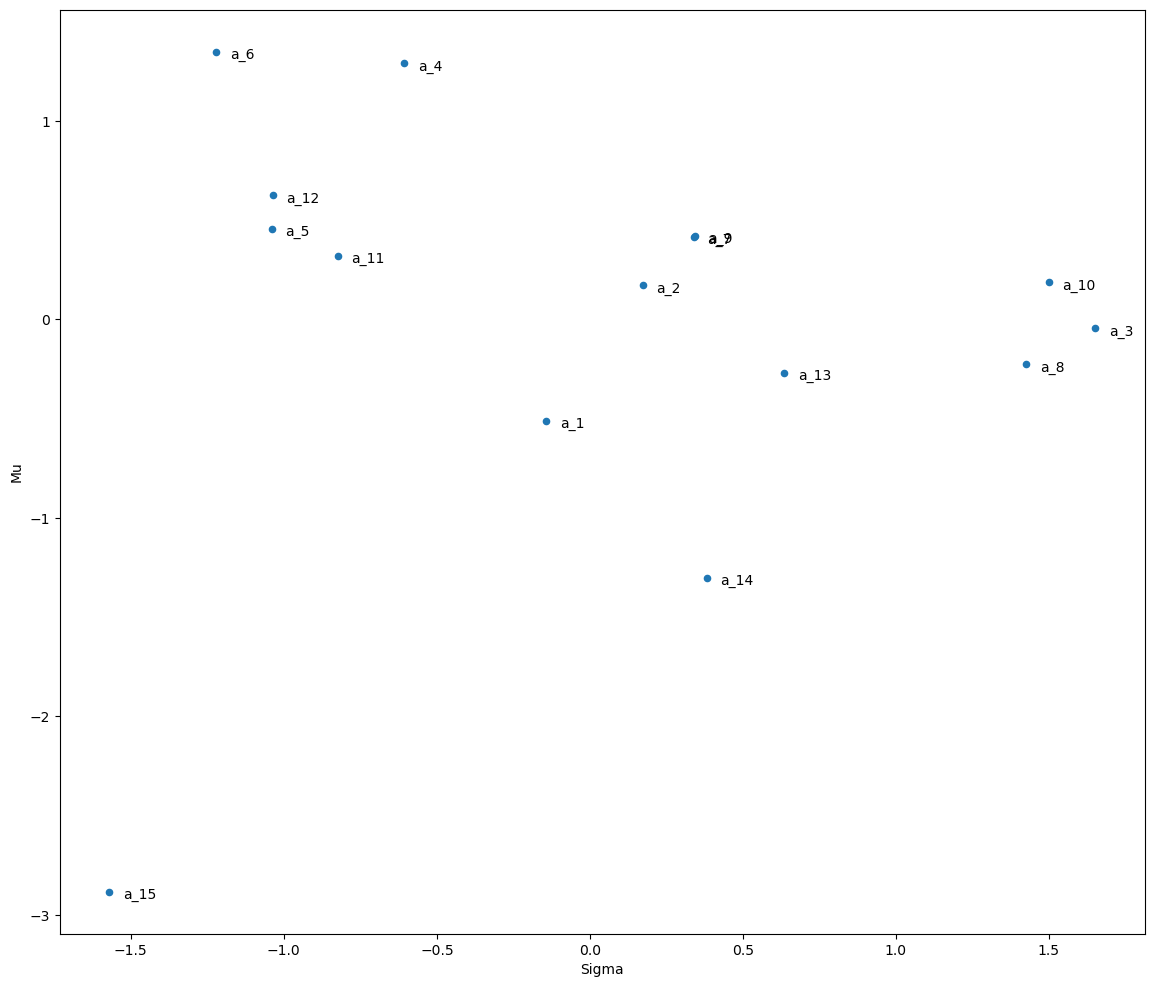

In [15]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df_transformed.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df_transformed.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df_transformed.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

### Get PKFs

Now, get the Pareto-Koopmans frontiers

In [16]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_6', 'a_15']
PKF_2: ['a_4', 'a_5', 'a_12']
PKF_3: ['a_7', 'a_9', 'a_11']
PKF_4: ['a_1', 'a_2', 'a_10']
PKF_5: ['a_3', 'a_8', 'a_13', 'a_14']


### Run the optimization model

Get the local efficiencies

In [17]:
lambda_ = 0

# Run optimization and get the local efficiences
m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()
        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, lambda_)
        local_ef_new[unit, fr] = M_new.obj()
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

### Get local and global efficiencies


In [18]:
# Print local efficiencies
pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$,$PKF_4$
$a_1$,-0.075828,-0.056133,-0.042592,0.000000,0.043039
$a_2$,-0.091832,-0.075941,-0.052095,0.000000,0.081574
$a_3$,-0.184136,-0.168585,-0.128265,-0.070225,0.000000
$a_4$,-0.018896,0.000000,0.276651,0.351446,0.424896
$a_5$,-0.015659,0.000000,0.033935,0.089662,0.164302
$a_6$,0.000000,0.036168,0.295547,0.370342,0.443792
$a_7$,-0.100861,-0.084018,-0.001277,0.072880,0.146330
$a_8$,-0.171080,-0.154409,-0.140869,-0.082527,-0.019737
$a_9$,-0.101025,-0.083977,0.000000,0.074795,0.148245
$a_10$,-0.173516,-0.156695,-0.074088,0.000000,0.073450


Now, lets calculate the global efficience and normalize it using min-max

In [19]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.254952,9.0
a_2,0.250997,10.0
a_3,0.010156,14.0
a_4,0.934819,2.0
a_5,0.490449,5.0
a_6,1.000000,1.0
a_7,0.350940,8.0
a_8,0.000000,15.0
a_9,0.353846,7.0
a_10,0.138686,12.0


# Model 1 with new constraint

In [20]:
# Print local efficiencies
pd.DataFrame(local_ef_new, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$,$PKF_4$
$a_1$,-0.075828,-0.056133,-0.042592,0.000000,0.043039
$a_2$,-0.091832,-0.075941,-0.052095,0.000000,0.081574
$a_3$,-0.184136,-0.168585,-0.128265,-0.070225,0.000000
$a_4$,-0.018896,0.000000,0.276651,0.351446,0.424896
$a_5$,-0.015659,0.000000,0.033935,0.089662,0.164302
$a_6$,0.000000,0.036168,0.295547,0.370342,0.443792
$a_7$,-0.100861,-0.084018,-0.001277,0.072880,0.146330
$a_8$,-0.171080,-0.154409,-0.140869,-0.082527,-0.019737
$a_9$,-0.101025,-0.083977,0.000000,0.074795,0.148245
$a_10$,-0.173516,-0.156695,-0.074088,0.000000,0.073450


In [21]:
global_ef_new = np.sum(local_ef_new, axis = 1)
global_ef_new = (global_ef_new - global_ef_new.min()) /(global_ef_new.max() - global_ef_new.min())

results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index)
results_new = results_new.assign(Position = results_new.rank(ascending=False))
results_new

,Global Efficiency,Position
a_1,0.254952,9.0
a_2,0.250997,10.0
a_3,0.010156,14.0
a_4,0.934819,2.0
a_5,0.490449,5.0
a_6,1.000000,1.0
a_7,0.350940,8.0
a_8,0.000000,15.0
a_9,0.353846,7.0
a_10,0.138686,12.0


### Testing different values for lambda

In [22]:
lambda_list = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
global_ef_list = []
results_list = []

for lamb in lambda_list:
    # Run optimization and get the local efficiences
    m = Sigma_Mu_df.shape[0] # number of alternatives
    m_f = len(PKF) # number of frontiers
    local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
    local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
    for unit in range (m):
        for fr in range (m_f):
            unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit        
            Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
            for k in range(fr, m_f):
                for l in range(len(PKF[k])):
                    Fr_list.append(PKF[k][l])
            Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
            M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, my_lambda= lamb)
            local_ef_new[unit, fr] = M_new.obj()
            print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

    global_ef_new = np.sum(local_ef_new, axis = 1)
    global_ef_new = (global_ef_new - global_ef_new.min()) /(global_ef_new.max() - global_ef_new.min())
    global_ef_list.append(global_ef_new)
    r_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index)
    r_new = r_new.assign(Position = r_new.rank(ascending=False))
    results_list.append(r_new)


alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

alternative 12, fronteira 5: resolvido.
alternative 13, fronteira 1: resolvido.
alternative 13, fronteira 2: resolvido.
alternative 13, fronteira 3: resolvido.
alternative 13, fronteira 4: resolvido.
alternative 13, fronteira 5: resolvido.
alternative 14, fronteira 1: resolvido.
alternative 14, fronteira 2: resolvido.
alternative 14, fronteira 3: resolvido.
alternative 14, fronteira 4: resolvido.
alternative 14, fronteira 5: resolvido.
alternative 15, fronteira 1: resolvido.
alternative 15, fronteira 2: resolvido.
alternative 15, fronteira 3: resolvido.
alternative 15, fronteira 4: resolvido.
alternative 15, fronteira 5: resolvido.
alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternati

alternative 9, fronteira 4: resolvido.
alternative 9, fronteira 5: resolvido.
alternative 10, fronteira 1: resolvido.
alternative 10, fronteira 2: resolvido.
alternative 10, fronteira 3: resolvido.
alternative 10, fronteira 4: resolvido.
alternative 10, fronteira 5: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 11, fronteira 2: resolvido.
alternative 11, fronteira 3: resolvido.
alternative 11, fronteira 4: resolvido.
alternative 11, fronteira 5: resolvido.
alternative 12, fronteira 1: resolvido.
alternative 12, fronteira 2: resolvido.
alternative 12, fronteira 3: resolvido.
alternative 12, fronteira 4: resolvido.
alternative 12, fronteira 5: resolvido.
alternative 13, fronteira 1: resolvido.
alternative 13, fronteira 2: resolvido.
alternative 13, fronteira 3: resolvido.
alternative 13, fronteira 4: resolvido.
alternative 13, fronteira 5: resolvido.
alternative 14, fronteira 1: resolvido.
alternative 14, fronteira 2: resolvido.
alternative 14, fronteira 3: resolvido.
al

alternative 6, fronteira 2: resolvido.
alternative 6, fronteira 3: resolvido.
alternative 6, fronteira 4: resolvido.
alternative 6, fronteira 5: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 7, fronteira 2: resolvido.
alternative 7, fronteira 3: resolvido.
alternative 7, fronteira 4: resolvido.
alternative 7, fronteira 5: resolvido.
alternative 8, fronteira 1: resolvido.
alternative 8, fronteira 2: resolvido.
alternative 8, fronteira 3: resolvido.
alternative 8, fronteira 4: resolvido.
alternative 8, fronteira 5: resolvido.
alternative 9, fronteira 1: resolvido.
alternative 9, fronteira 2: resolvido.
alternative 9, fronteira 3: resolvido.
alternative 9, fronteira 4: resolvido.
alternative 9, fronteira 5: resolvido.
alternative 10, fronteira 1: resolvido.
alternative 10, fronteira 2: resolvido.
alternative 10, fronteira 3: resolvido.
alternative 10, fronteira 4: resolvido.
alternative 10, fronteira 5: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 11, fro

In [23]:
pd.concat(results_list, axis = 1)

,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position,Global Efficiency,Position
a_1,0.254952,9.0,0.204878,10.0,0.352864,10.0,0.415442,12.0,0.449492,12.0,0.470537,13.0,0.485029,13.0,0.495616,13.0,0.503689,13.0
a_2,0.250997,10.0,0.295345,8.0,0.469265,8.0,0.542808,8.0,0.583681,8.0,0.609781,8.0,0.627753,8.0,0.640883,8.0,0.650894,8.0
a_3,0.010156,14.0,0.087565,12.0,0.323379,12.0,0.423095,10.0,0.478728,10.0,0.514460,10.0,0.539064,10.0,0.557039,10.0,0.570745,10.0
a_4,0.934819,2.0,0.943381,2.0,0.960569,2.0,0.967837,2.0,0.971881,2.0,0.974467,2.0,0.976249,2.0,0.977550,2.0,0.978542,2.0
a_5,0.490449,5.0,0.509408,4.0,0.623360,4.0,0.671546,4.0,0.698409,4.0,0.715644,4.0,0.727511,4.0,0.736181,4.0,0.742792,4.0
a_6,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
a_7,0.350940,8.0,0.399618,7.0,0.552223,7.0,0.616753,7.0,0.652767,7.0,0.675908,7.0,0.691843,6.0,0.703484,6.0,0.712360,6.0
a_8,0.000000,15.0,0.057944,13.0,0.291141,13.0,0.389750,13.0,0.444218,13.0,0.478678,12.0,0.502407,12.0,0.519742,12.0,0.532961,12.0
a_9,0.353846,7.0,0.402476,6.0,0.554468,6.0,0.618740,6.0,0.654608,6.0,0.677655,5.0,0.693525,5.0,0.705119,5.0,0.713960,5.0
a_10,0.138686,12.0,0.212368,9.0,0.418643,9.0,0.505869,9.0,0.554522,9.0,0.585759,9.0,0.607269,9.0,0.622983,9.0,0.634965,9.0


# Model 2

In [24]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_pos,"Mu": mu_pos}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.029210,0.144517
a_2,0.055536,0.253214
a_3,0.117519,0.275964
a_4,0.080957,0.446491
a_5,0.042871,0.259356
a_6,0.055487,0.453200
a_7,0.067960,0.294509
a_8,0.118346,0.275840
a_9,0.088917,0.296517
a_10,0.142522,0.326131


Before plotting the results, lets procceed with a standard normalization.

In [25]:
Sigma_Mu_df_transformed = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df_transformed = pd.DataFrame(Sigma_Mu_df_transformed, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df_transformed

,Sigma,Mu
a_1,-0.985738,-0.987802
a_2,-0.268678,-0.027365
a_3,1.419593,0.173652
a_4,0.423723,1.680412
a_5,-0.613643,0.026906
a_6,-0.270001,1.739693
a_7,0.069724,0.337519
a_8,1.442126,0.172560
a_9,0.640554,0.355259
a_10,2.100624,0.616922


Plot the $\sigma-\mu$ figure 

C:\Users\igor2\AppData\Local\Temp\ipykernel_12912\188652928.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


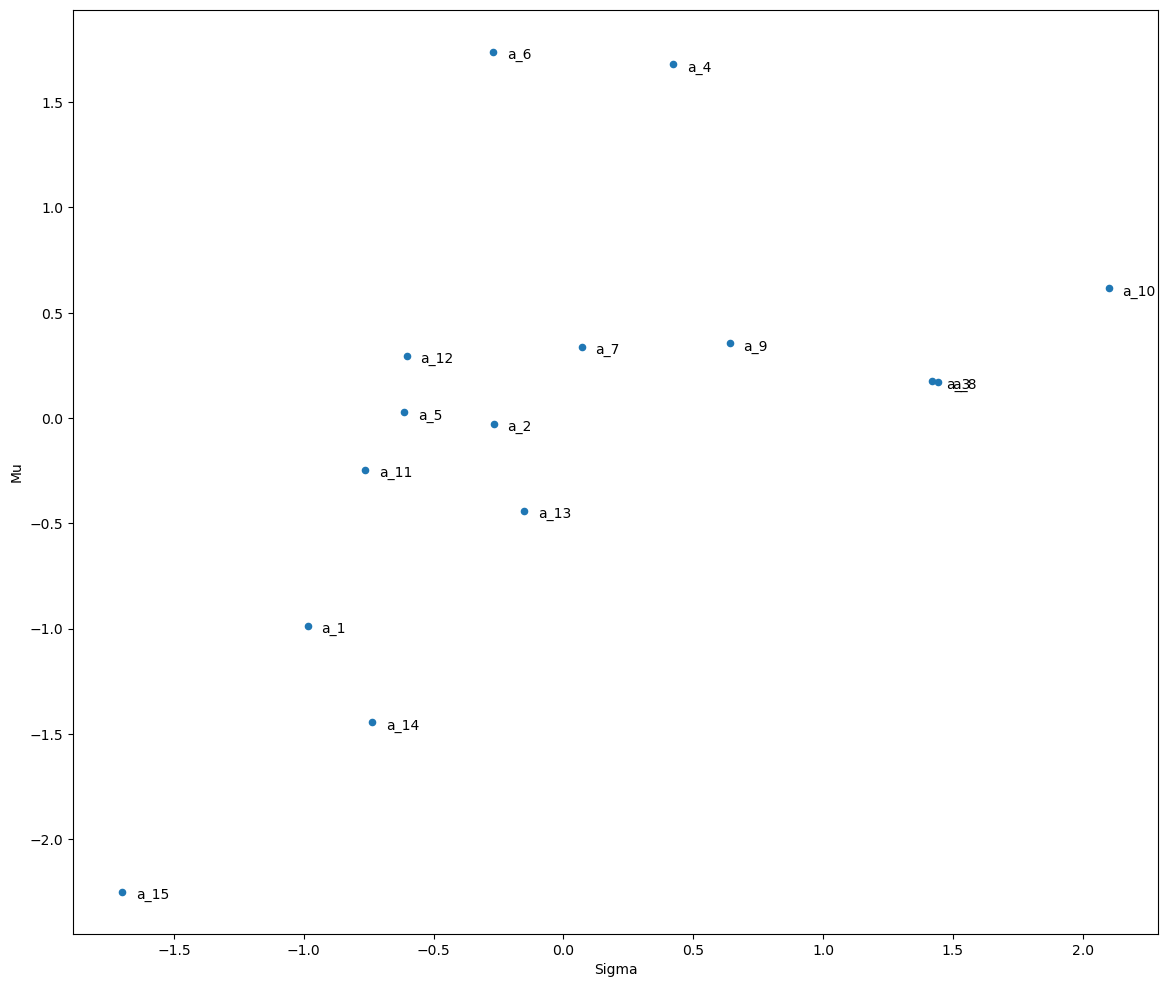

In [26]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df_transformed.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df_transformed.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df_transformed.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, get the Pareto-Koopmans frontiers

In [27]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_1', 'a_5', 'a_6', 'a_11', 'a_12', 'a_15']
PKF_2: ['a_2', 'a_4', 'a_7', 'a_14']
PKF_3: ['a_9', 'a_10', 'a_13']
PKF_4: ['a_3']
PKF_5: ['a_8']


In [28]:
from PROMETHEE import optimize_PROM1_original_pos_flow

In [29]:
# Run optimization and get the local efficiences

lambda_ = 0

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, lambda_)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

In [30]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$,$PKF_4$
$a_1$,-0.008601,0.013223,0.030580,0.088308,0.089136
$a_2$,-0.020867,0.000000,0.014659,0.061983,0.062810
$a_3$,-0.074027,-0.052134,-0.023417,0.000000,0.000827
$a_4$,-0.006709,0.000000,0.120360,0.170527,0.170650
$a_5$,-0.008882,0.012032,0.025731,0.074647,0.075475
$a_6$,0.000000,0.023289,0.127069,0.177236,0.177359
$a_7$,-0.027698,-0.006180,0.015350,0.049559,0.050386
$a_8$,-0.074781,-0.052879,-0.023791,-0.000124,0.000000
$a_9$,-0.046264,-0.024468,0.000000,0.028601,0.029429
$a_10$,-0.091203,-0.068399,0.000000,0.050167,0.050290


Now, lets calculate the global efficience and normalize it using min-max

In [31]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.554770,4.0
a_2,0.411497,9.0
a_3,0.004302,14.0
a_4,0.923652,2.0
a_5,0.503526,7.0
a_6,1.000000,1.0
a_7,0.354886,10.0
a_8,0.000000,15.0
a_9,0.211527,12.0
a_10,0.140786,13.0


# Model 3

In [32]:
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_neg,"Mu": mu_neg}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.100636,0.307193
a_2,0.090563,0.198326
a_3,0.141253,0.290106
a_4,0.018943,0.035736
a_5,0.033291,0.114076
a_6,0.012594,0.023550
a_7,0.094789,0.162321
a_8,0.116411,0.348057
a_9,0.074670,0.162415
a_10,0.099638,0.266823


Before plotting the results, lets procceed with a standard normalization.

In [33]:
Sigma_Mu_df_transformed = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df_transformed = pd.DataFrame(Sigma_Mu_df_transformed, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df_transformed

,Sigma,Mu
a_1,0.610123,0.234548
a_2,0.364819,-0.267289
a_3,1.599325,0.155782
a_4,-1.379441,-1.016764
a_5,-1.030016,-0.655648
a_6,-1.534082,-1.072940
a_7,0.467742,-0.433256
a_8,0.994315,0.422916
a_9,-0.022257,-0.432827
a_10,0.585825,0.048455


Plot the $\sigma-\mu$ figure 

C:\Users\igor2\AppData\Local\Temp\ipykernel_12912\3789348243.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


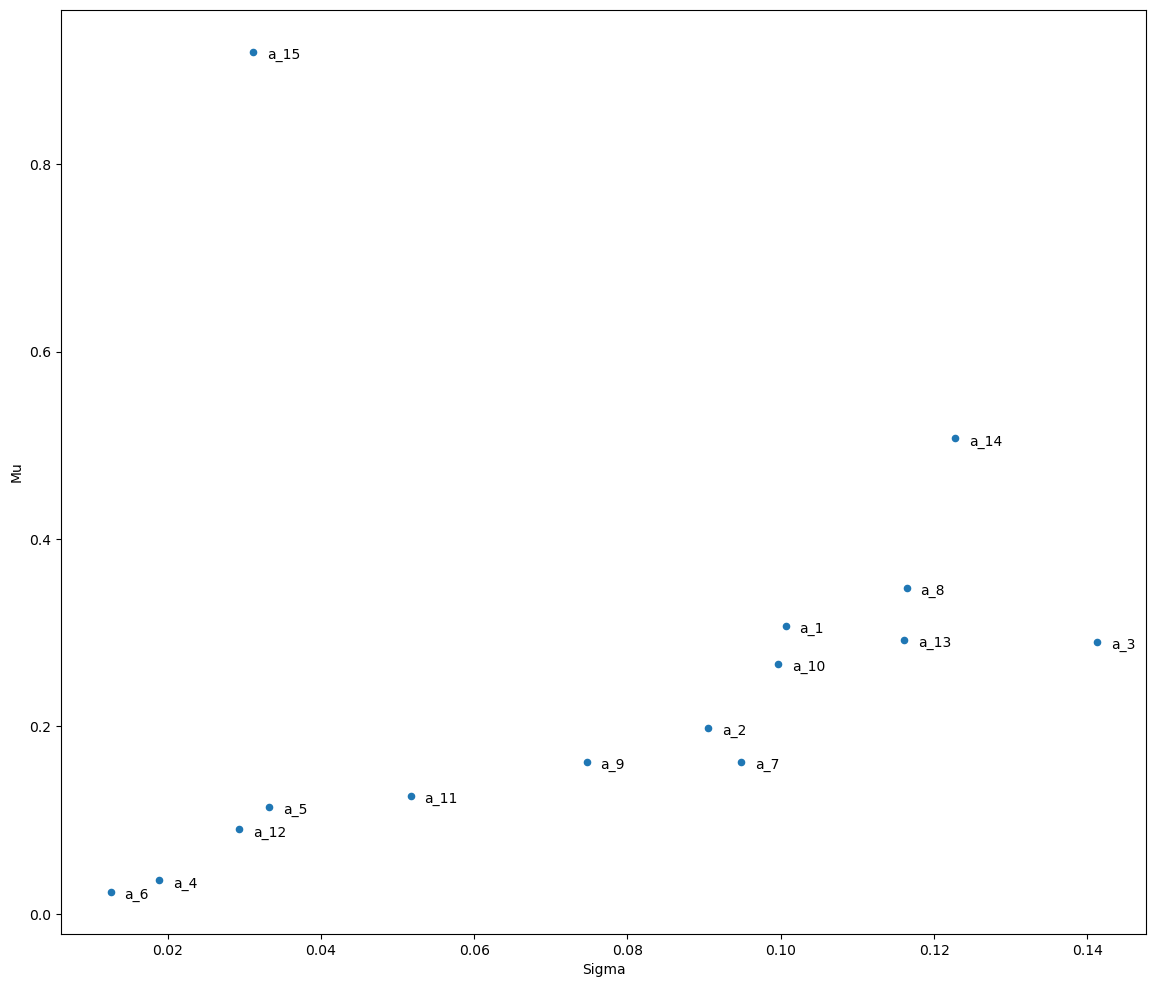

In [34]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, get the Pareto-Koopmans frontiers

In [35]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_4', 'a_6', 'a_12', 'a_15']
PKF_2: ['a_1', 'a_2', 'a_5', 'a_8', 'a_9', 'a_10', 'a_11', 'a_14']
PKF_3: ['a_7', 'a_13']
PKF_4: ['a_3']


In [36]:
from PROMETHEE import optimize_PROM1_original_neg_flow

In [37]:
# Run optimization and get the local efficiences
lambda_ = 0
m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, lambda_)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 6, fronteira 1: resolvido.
alternative 6, fronteira 2: resolvido.
alternative 6, fronteira 3: resolvido.
alternative 6, fronteira 4: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 7, fronteira 

In [38]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$,$PKF_1$,$PKF_2$,$PKF_3$
$a_1$,-0.080493,-0.019090,0.015329,0.040617
$a_2$,-0.072836,-0.031053,0.008691,0.050689
$a_3$,-0.120632,-0.055348,-0.002245,0.000000
$a_4$,-0.005973,0.014348,0.075846,0.122310
$a_5$,-0.018438,0.000000,0.061499,0.107962
$a_6$,0.000000,0.020697,0.082196,0.128659
$a_7$,-0.077708,-0.041167,0.000000,0.046463
$a_8$,-0.095117,-0.024372,0.055707,0.057952
$a_9$,-0.057995,-0.024757,0.020120,0.066583
$a_10$,-0.080335,-0.025757,0.010515,0.041615


Now, lets calculate the global efficience and normalize it using min-max

In [39]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=True))
results

,Global Efficiency,Position
a_1,0.072802,6.0
a_2,0.072330,5.0
a_3,0.000000,1.0
a_4,0.208122,12.0
a_5,0.178097,10.0
a_6,0.221657,13.0
a_7,0.057237,3.0
a_8,0.093252,7.0
a_9,0.098542,8.0
a_10,0.067216,4.0


# Model 4

In [40]:

mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma_pos": sigma_pos,"Mu_pos": mu_pos, "Sigma_neg": sigma_neg,"Mu_neg": mu_neg}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma_pos,Mu_pos,Sigma_neg,Mu_neg
a_1,0.029210,0.144517,0.100636,0.307193
a_2,0.055536,0.253214,0.090563,0.198326
a_3,0.117519,0.275964,0.141253,0.290106
a_4,0.080957,0.446491,0.018943,0.035736
a_5,0.042871,0.259356,0.033291,0.114076
a_6,0.055487,0.453200,0.012594,0.023550
a_7,0.067960,0.294509,0.094789,0.162321
a_8,0.118346,0.275840,0.116411,0.348057
a_9,0.088917,0.296517,0.074670,0.162415
a_10,0.142522,0.326131,0.099638,0.266823


Before plotting the results, lets procceed with a standard normalization.

In [41]:
Sigma_Mu_df_transformed = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df_transformed = pd.DataFrame(Sigma_Mu_df_transformed, columns=['Sigma_pos', 'Mu_pos', 'Sigma_neg', 'Mu_neg'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df_transformed

,Sigma_pos,Mu_pos,Sigma_neg,Mu_neg
a_1,-0.985738,-0.987802,0.610123,0.234548
a_2,-0.268678,-0.027365,0.364819,-0.267289
a_3,1.419593,0.173652,1.599325,0.155782
a_4,0.423723,1.680412,-1.379441,-1.016764
a_5,-0.613643,0.026906,-1.030016,-0.655648
a_6,-0.270001,1.739693,-1.534082,-1.072940
a_7,0.069724,0.337519,0.467742,-0.433256
a_8,1.442126,0.172560,0.994315,0.422916
a_9,0.640554,0.355259,-0.022257,-0.432827
a_10,2.100624,0.616922,0.585825,0.048455


Now, get the Pareto-Koopmans frontiers

In [42]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                # loose dimension 0
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 1
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 2
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] > comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 3
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] < comp_df.iloc[i,3])),
                # loose dimension 0 and 1
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 0 and 2
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] > comp_df.iloc[i,2]) and (df.loc[idx][3] == comp_df.iloc[i,3])),
                # loose dimension 0 and 3
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1]) and (df.loc[idx][2] == comp_df.iloc[i,2]) and (df.loc[idx][3] < comp_df.iloc[i,3])),
                # loose dimension 1 and 2
                # loose dimension 1 and 3
                # loose dimension 2 and 3
                # loose dimension 0, 1 and 2
                # loose dimension 0, 1 and 3
                # loose dimension 0, 2 and 3
                # loose dimension 1, 2 and 3
                # loose dimension 0, 1, 2 and 3

                ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        print('deu falso')
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'a_7', 'a_8', 'a_9', 'a_10', 'a_11', 'a_12', 'a_13', 'a_14', 'a_15']


In [43]:
PKF

[['a_1',
  'a_2',
  'a_3',
  'a_4',
  'a_5',
  'a_6',
  'a_7',
  'a_8',
  'a_9',
  'a_10',
  'a_11',
  'a_12',
  'a_13',
  'a_14',
  'a_15']]

In [44]:
from PROMETHEE import optimize_PROM1_original_pos_flow

In [45]:
# Run optimization and get the local efficiences
lambda_=0
m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, lambda_)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 6, fronteira 1: resolvido.
alternative 7, fronteira 1: resolvido.
alternative 8, fronteira 1: resolvido.
alternative 9, fronteira 1: resolvido.
alternative 10, fronteira 1: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 12, fronteira 1: resolvido.
alternative 13, fronteira 1: resolvido.
alternative 14, fronteira 1: resolvido.
alternative 15, fronteira 1: resolvido.


In [46]:
# Print local efficiencies

pd.DataFrame(local_ef, columns = ['$PKF_' + str(i) +'$' for i in range(len(PKF))], index=A.index)

,$PKF_0$
$a_1$,-0.008601
$a_2$,-0.020867
$a_3$,-0.074027
$a_4$,-0.006709
$a_5$,-0.008882
$a_6$,0.000000
$a_7$,-0.027698
$a_8$,-0.074781
$a_9$,-0.046264
$a_10$,-0.091203


Now, lets calculate the global efficience and normalize it using min-max

In [47]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())

results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.905692,6.0
a_2,0.771198,8.0
a_3,0.188326,13.0
a_4,0.926438,4.0
a_5,0.902615,7.0
a_6,1.000000,1.5
a_7,0.696306,10.0
a_8,0.180059,14.0
a_9,0.492739,12.0
a_10,0.000000,15.0


# Modified Model 1

In [48]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df


,Sigma,Mu
a_1,0.121442,-0.162676
a_2,0.141251,0.054888
a_3,0.233933,-0.014142
a_4,0.092389,0.410754
a_5,0.065309,0.145280
a_6,0.054026,0.429650
a_7,0.151685,0.132188
a_8,0.219719,-0.072217
a_9,0.151883,0.134103
a_10,0.224337,0.059308


In [49]:
Sigma_Mu_df_transformed = StandardScaler().fit_transform(Sigma_Mu_df)
Sigma_Mu_df_transformed = pd.DataFrame(Sigma_Mu_df_transformed, columns=['Sigma', 'Mu'], index = ['a_' + str(i+1) for i in range (m)])
Sigma_Mu_df_transformed

,Sigma,Mu
a_1,-0.144148,-0.510800
a_2,0.172112,0.172347
a_3,1.651851,-0.044405
a_4,-0.608003,1.289759
a_5,-1.040346,0.456176
a_6,-1.220494,1.349092
a_7,0.338709,0.415068
a_8,1.424914,-0.226760
a_9,0.341861,0.421080
a_10,1.498640,0.186226


C:\Users\igor2\AppData\Local\Temp\ipykernel_12912\188652928.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


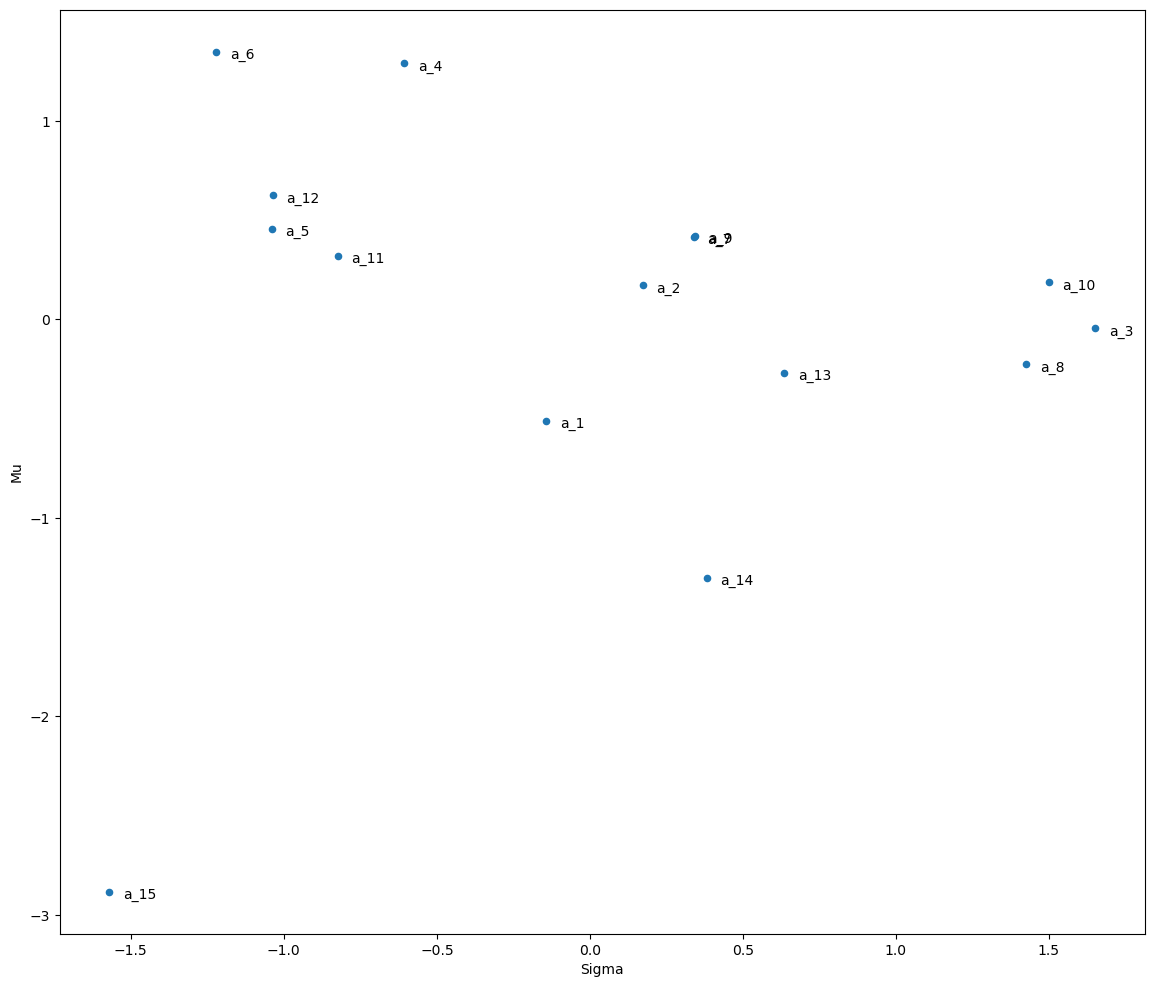

In [50]:
from matplotlib.pyplot import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
Sigma_Mu_df_transformed.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (14,12))
for k, v in Sigma_Mu_df_transformed.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')
for k, v in Sigma_Mu_df_transformed.iterrows():
    if (k=='North Korea'):
        plt.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='red')

Now, the rule for getting PKFs is changed

In [51]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['a_3', 'a_4', 'a_6', 'a_9', 'a_10']
PKF_2: ['a_7', 'a_8', 'a_12']
PKF_3: ['a_2', 'a_5', 'a_11', 'a_13']
PKF_4: ['a_1', 'a_14']
PKF_5: ['a_15']


In [52]:
lambda_ = 0
m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM2_original_positive_beta(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu, lambda_)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2, fronteira 5: resolvido.
alternative 3, fronteira 1: resolvido.
alternative 3, fronteira 2: resolvido.
alternative 3, fronteira 3: resolvido.
alternative 3, fronteira 4: resolvido.
alternative 3, fronteira 5: resolvido.
alternative 4, fronteira 1: resolvido.
alternative 4, fronteira 2: resolvido.
alternative 4, fronteira 3: resolvido.
alternative 4, fronteira 4: resolvido.
alternative 4, fronteira 5: resolvido.
alternative 5, fronteira 1: resolvido.
alternative 5, fronteira 2: resolvido.
alternative 5, fronteira 3: resolvido.
alternative 5, fronteira 4: resolvido.
alternative 5, fronteira 5: resolvido.
alternative 6, fronteira 

In [54]:
global_ef = np.sum(local_ef, axis = 1)
global_ef = (global_ef - global_ef.min()) /(global_ef.max() - global_ef.min())
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index)
results = results.assign(Position = results.rank(ascending=False))
results

,Global Efficiency,Position
a_1,0.369744,13.0
a_2,0.564288,10.0
a_3,0.577460,8.0
a_4,0.975657,2.0
a_5,0.611589,7.0
a_6,1.000000,1.0
a_7,0.645250,5.0
a_8,0.524565,11.0
a_9,0.647388,4.0
a_10,0.629841,6.0


Alternativa $a_3$ agora está na oitava posição ao invés da posição 14.

Vamos ver o comportamento dessa alternativa.

In [55]:
Net_Flows.shape

(15, 10000)

In [56]:
Net_Flows_df = pd.DataFrame(Net_Flows, columns = [s for s in range(n_simulations)], index = A.index)
Net_Flows_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$a_1$,-0.104589,-0.155586,-0.024488,-0.354331,-0.258992,-0.013874,-0.012378,-0.107444,-0.288860,-0.123435,...,-0.068543,-0.119021,-0.126722,-0.371199,-0.163514,-0.074096,-0.161694,-0.046127,-0.010107,-0.187785
$a_2$,0.132150,-0.109014,0.234513,-0.013235,0.208160,0.094653,0.064205,-0.117482,0.212090,0.126494,...,-0.038741,-0.024938,0.018670,0.310836,0.027134,0.105395,0.088362,0.001075,0.044557,0.010871
$a_3$,-0.013021,0.321053,-0.064464,-0.304934,0.146360,0.024342,-0.062449,0.262313,-0.001203,-0.079067,...,0.191025,0.208962,-0.133658,0.206184,0.024527,0.228786,0.139161,0.163776,0.101543,-0.272889
$a_4$,0.390730,0.290680,0.389997,0.544361,0.451800,0.329678,0.323082,0.313795,0.502504,0.389966,...,0.386405,0.339726,0.271187,0.548607,0.293499,0.323686,0.396881,0.365029,0.321571,0.391567
$a_5$,0.175180,0.039851,0.234420,0.109174,0.149958,0.171818,0.161682,0.118539,0.178171,0.164862,...,0.166093,0.114995,0.052905,0.194822,0.084598,0.183590,0.173479,0.202926,0.169591,0.068353
$a_6$,0.383205,0.388269,0.428106,0.527224,0.422699,0.412419,0.400647,0.350166,0.459851,0.392602,...,0.378529,0.411657,0.438774,0.459802,0.392695,0.355924,0.400378,0.390544,0.374024,0.477701
$a_7$,0.040749,0.302400,-0.108090,0.177855,0.382222,-0.040570,-0.077853,0.183503,0.318558,0.113194,...,-0.053838,0.234853,0.115274,0.545577,0.241539,0.068583,0.142600,0.016522,-0.028050,0.138585
$a_8$,-0.143469,0.222842,-0.106827,-0.191689,-0.208476,0.084927,0.051707,0.010077,-0.242991,-0.120103,...,-0.114715,0.099801,0.397071,-0.397106,0.162605,-0.031625,-0.138349,-0.139683,0.060201,0.170607
$a_9$,0.079461,0.273153,-0.061602,0.143000,0.440656,-0.037550,-0.091448,0.189222,0.356654,0.121912,...,-0.027086,0.207431,0.079391,0.632767,0.203712,0.141175,0.189355,0.026754,0.000558,0.073253
$a_10$,-0.007608,0.165616,-0.031543,0.180026,-0.214053,0.143415,0.220827,-0.008088,-0.117143,0.063903,...,-0.085617,0.088053,0.612236,-0.404747,0.330775,-0.148155,-0.134783,-0.127766,0.044851,0.477935


In [57]:
Net_Flows_rank = Net_Flows_df.rank(ascending=False)
Net_Flows_rank

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
$a_1$,12.0,12.0,8.0,14.0,12.0,11.0,10.0,11.0,13.0,13.0,...,11.0,12.0,12.0,10.0,12.0,11.0,13.0,10.0,11.0,12.0
$a_2$,5.0,11.0,3.0,9.0,5.0,6.0,8.0,12.0,5.0,5.0,...,8.0,11.0,9.0,5.0,9.0,7.0,9.0,9.0,9.0,11.0
$a_3$,11.0,2.0,11.0,13.0,8.0,9.0,11.0,3.0,9.0,11.0,...,5.0,4.0,13.0,6.0,10.0,4.0,7.0,6.0,6.0,13.0
$a_4$,1.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0
$a_5$,4.0,10.0,4.0,8.0,7.0,4.0,5.0,8.0,7.0,4.0,...,6.0,7.0,7.0,7.0,8.0,5.0,5.0,5.0,4.0,8.0
$a_6$,2.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,...,2.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0
$a_7$,8.0,3.0,13.0,5.0,4.0,13.0,12.0,7.0,4.0,7.0,...,9.0,3.0,5.0,3.0,4.0,9.0,6.0,8.0,12.0,5.0
$a_8$,13.0,6.0,12.0,11.0,10.0,7.0,9.0,9.0,12.0,12.0,...,13.0,8.0,3.0,12.0,6.0,10.0,11.0,12.0,7.0,4.0
$a_9$,7.0,5.0,10.0,7.0,2.0,12.0,13.0,6.0,3.0,6.0,...,7.0,5.0,6.0,1.0,5.0,6.0,4.0,7.0,10.0,7.0
$a_10$,10.0,7.0,9.0,4.0,11.0,5.0,3.0,10.0,10.0,9.0,...,12.0,9.0,1.0,13.0,2.0,13.0,10.0,11.0,8.0,1.0


In [58]:
# Porcentagem de vezes que a_3 vence a_11

count = 0
for j in range (n_simulations):
    if Net_Flows_rank.loc['$a_3$'][j] < Net_Flows_rank.loc['$a_11$'][j]:
        count += 1

count/n_simulations

0.334

In [59]:
# Mode over alternative positions
Net_Flows_rank.mode(axis = 1)

,0
$a_1$,12.0
$a_2$,5.0
$a_3$,13.0
$a_4$,2.0
$a_5$,4.0
$a_6$,1.0
$a_7$,4.0
$a_8$,11.0
$a_9$,3.0
$a_10$,10.0


In [60]:
Net_Flows_rank_counts = Net_Flows_rank.apply(pd.Series.value_counts, axis = 1).fillna(0)
Net_Flows_rank_counts

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
$a_1$,0.0,0.0,0.0,0.0,0.0,0.0,128.0,413.0,499.0,658.0,2054.0,3307.0,2571.0,370.0,0.0
$a_2$,0.0,0.0,295.0,273.0,1601.0,1012.0,931.0,1145.0,1442.0,902.0,1158.0,1109.0,132.0,0.0,0.0
$a_3$,479.0,193.0,350.0,368.0,623.0,623.0,475.0,934.0,1117.0,955.0,850.0,1015.0,1394.0,624.0,0.0
$a_4$,3855.0,4255.0,1140.0,608.0,104.0,21.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$a_5$,0.0,3.0,29.0,2174.0,1309.0,1794.0,2172.0,1474.0,493.0,552.0,0.0,0.0,0.0,0.0,0.0
$a_6$,4866.0,4689.0,357.0,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$a_7$,0.0,37.0,1102.0,2403.0,1238.0,752.0,980.0,766.0,967.0,509.0,474.0,359.0,350.0,63.0,0.0
$a_8$,5.0,148.0,435.0,647.0,292.0,373.0,337.0,416.0,746.0,1297.0,1677.0,1374.0,1195.0,1058.0,0.0
$a_9$,173.0,121.0,1609.0,1174.0,894.0,1078.0,1023.0,1208.0,871.0,896.0,400.0,364.0,189.0,0.0,0.0
$a_10$,565.0,478.0,1239.0,294.0,451.0,376.0,432.0,825.0,1081.0,1616.0,1020.0,718.0,802.0,103.0,0.0


In [61]:
Net_Flows_rank_probs = Net_Flows_rank_counts/n_simulations
Net_Flows_rank_probs

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
$a_1$,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0128,0.0413,0.0499,0.0658,0.2054,0.3307,0.2571,0.0370,0.0
$a_2$,0.0000,0.0000,0.0295,0.0273,0.1601,0.1012,0.0931,0.1145,0.1442,0.0902,0.1158,0.1109,0.0132,0.0000,0.0
$a_3$,0.0479,0.0193,0.0350,0.0368,0.0623,0.0623,0.0475,0.0934,0.1117,0.0955,0.0850,0.1015,0.1394,0.0624,0.0
$a_4$,0.3855,0.4255,0.1140,0.0608,0.0104,0.0021,0.0012,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
$a_5$,0.0000,0.0003,0.0029,0.2174,0.1309,0.1794,0.2172,0.1474,0.0493,0.0552,0.0000,0.0000,0.0000,0.0000,0.0
$a_6$,0.4866,0.4689,0.0357,0.0085,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
$a_7$,0.0000,0.0037,0.1102,0.2403,0.1238,0.0752,0.0980,0.0766,0.0967,0.0509,0.0474,0.0359,0.0350,0.0063,0.0
$a_8$,0.0005,0.0148,0.0435,0.0647,0.0292,0.0373,0.0337,0.0416,0.0746,0.1297,0.1677,0.1374,0.1195,0.1058,0.0
$a_9$,0.0173,0.0121,0.1609,0.1174,0.0894,0.1078,0.1023,0.1208,0.0871,0.0896,0.0400,0.0364,0.0189,0.0000,0.0
$a_10$,0.0565,0.0478,0.1239,0.0294,0.0451,0.0376,0.0432,0.0825,0.1081,0.1616,0.1020,0.0718,0.0802,0.0103,0.0


In [62]:
pd.DataFrame(Net_Flows_rank_probs.max(axis=1))

,0
$a_1$,0.3307
$a_2$,0.1601
$a_3$,0.1394
$a_4$,0.4255
$a_5$,0.2174
$a_6$,0.4866
$a_7$,0.2403
$a_8$,0.1677
$a_9$,0.1609
$a_10$,0.1616


In [63]:
SumProduct_rank_probs = Net_Flows_rank_probs * [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
Net_Flows_expected_rank = SumProduct_rank_probs.sum(axis = 1)
pd.DataFrame(Net_Flows_expected_rank)

,0
$a_1$,11.6152
$a_2$,8.1491
$a_3$,8.9028
$a_4$,1.8987
$a_5$,6.3051
$a_6$,1.5670
$a_7$,6.5429
$a_8$,9.8545
$a_9$,6.5725
$a_10$,7.8142
